## Debugging notebook 2

From `SolarMED-optimization`


In [2]:
from pathlib import Path
import os
import hjson
import numpy as np
import pandas as pd
from IPython.display import display
from loguru import logger
import time
import pickle

# Visualization
from phd_visualizations.test_timeseries import experimental_results_plot
from phd_visualizations import save_figure
from phd_visualizations.constants import generate_plotly_config

# Model
from solarMED_modeling.solar_med import SolarMED
from solarMED_modeling.utils.matlab_environment import set_matlab_environment

set_matlab_environment()
logger.enable("solarMED_modeling")

# auto reload modules
%load_ext autoreload
%autoreload 2

data_path: Path = Path("/home/jmserrano/development_psa/SolarMED-optimization/debugging")

# Resample figures using plotly_resampler
resample_figures = False

# Parameters
# cost_w: float = 3 # €/m³, cost of water
# cost_e: float = 0.05 # €/kWh, cost of electricity

In [3]:
# Load given decision variables and environment variables

dec_vars = pd.read_csv(data_path / "dec_vars_error.csv", index_col=0)
env_vars = pd.read_csv(data_path / "env_vars_error.csv", index_col=0)

with open(data_path / "model_instance_error.pkl", "rb") as f:
    model_dict = pickle.load(f)

# sample_rate_numeric = ga_dict['sample_time']

<Axes: >

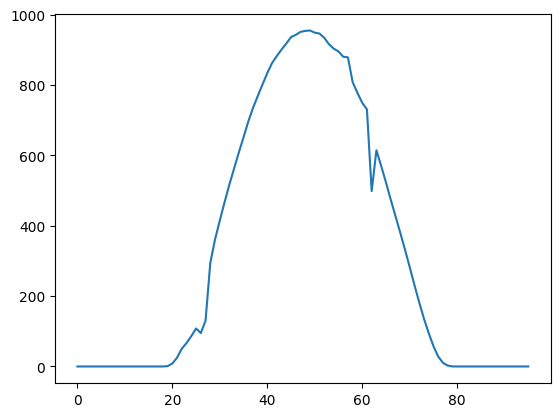

In [4]:
env_vars['I'].plot()

In [17]:
# Test model

idx_start = 0
idx_end = env_vars.shape[0]
df_mod = pd.DataFrame()
n_of_dec_vars_updates = int(np.ceil(env_vars.shape[0]/dec_vars.shape[0]))

# Initialize model
model = SolarMED(**model_dict)

# model = SolarMED(
#     resolution_mode='simple',
#     use_models=True,
#     use_finite_state_machine=True,
#     
#     sample_time=sample_rate_numeric,
#     
#     # If a slow sample time is used, the solar field internal PID needs to be detuned
#     # Ki_sf=-0.0001,
#     # Kp_sf=-0.005,
#     
#     # Initial states
#     ## Thermal storage
#     Tts_h=[df['Tts_h_t'].iloc[idx_start], df['Tts_h_m'].iloc[idx_start], df['Tts_h_b'].iloc[idx_start]], 
#     Tts_c=[df['Tts_c_t'].iloc[idx_start], df['Tts_c_m'].iloc[idx_start], df['Tts_c_b'].iloc[idx_start]],
#     
#     ## Solar field
#     Tsf_in_ant=df['Tsf_in'].iloc[idx_start-span:idx_start].values,
#     msf_ant=df['qsf'].iloc[idx_start-span:idx_start].values,
#     
#     # cost_w = 3, # €/m³ 
#     # cost_e = 0.05, # €/kWhe,
# )

# Run model
for idx in range(idx_start, idx_end):
    # idx = 1
    dv = dec_vars.iloc[idx//n_of_dec_vars_updates]
    ev = env_vars.iloc[idx]
    
    # logger.info(f"Iteration {idx} / {idx_end}")
    start_time = time.time()
        
    model.step(
        # Decision variables
        ## MED
        mmed_s=dv['mmed_s'],
        mmed_f=dv['mmed_f'],
        Tmed_s_in=dv['Tmed_s_in'],
        Tmed_c_out=dv['Tmed_c_out'],
        med_vacuum_state=int(dv['med_vacuum_state']),
        ## Thermal storage
        mts_src=dv['mts_src'],
        ## Solar field
        Tsf_out=dv['Tsf_out'],
        
        # Environment variables
        Tmed_c_in=ev['Tmed_c_in'],
        Tamb=ev['Tamb'],
        I=ev['I'],
    )
    
    logger.info(f"Finished Iteration {idx} / {idx_end} - elapsed time: {time.time()-start_time:.2f} seconds.")

    df_mod = model.to_dataframe(df_mod)

2024-05-23 14:51:53.598 | DEBUG    | solarMED_modeling.power_consumption:get_actuator_coefficients:81 - Custom coefficients provided for actuator med_brine_pump. Skipping default coefficients.
2024-05-23 14:51:53.599 | DEBUG    | solarMED_modeling.power_consumption:get_actuator_coefficients:81 - Custom coefficients provided for actuator med_feed_pump. Skipping default coefficients.
2024-05-23 14:51:53.599 | DEBUG    | solarMED_modeling.power_consumption:get_actuator_coefficients:81 - Custom coefficients provided for actuator med_distillate_pump. Skipping default coefficients.
2024-05-23 14:51:53.600 | DEBUG    | solarMED_modeling.power_consumption:get_actuator_coefficients:81 - Custom coefficients provided for actuator med_cooling_pump. Skipping default coefficients.
2024-05-23 14:51:53.600 | DEBUG    | solarMED_modeling.power_consumption:get_actuator_coefficients:81 - Custom coefficients provided for actuator med_heatsource_pump. Skipping default coefficients.
2024-05-23 14:51:53.601 

ValidationError: 1 validation error for SolarMED
Tsf_out
  Input should be less than or equal to 120 [type=less_than_equal, input_value=124.00975284412877, input_type=float64]
    For further information visit https://errors.pydantic.dev/2.7/v/less_than_equal

In [ ]:
model.current_sample

In [14]:
# Sync model index with measured data

# Update plot config
with open( Path("data") / "plot_config.hjson") as f:
    plt_config = hjson.load(f)
plt_config["plots"]["costs"]["traces_left"][0]["var_id"] = 'net_profit'
plt_config["plots"]["heat_exchanger_flows"]["traces_left"].pop(-1)
plt_config["plots"]["thermal_storage_flows"]["traces_left"].pop(-1)
plt_config["plots"]["thermal_storage_flows"]["traces_left"].pop(-1)
plt_config["plots"]["med_temperatures"].pop("traces_right", None)

fig = experimental_results_plot(plt_config, df_mod, resample=resample_figures)

fig.show(
    config=generate_plotly_config(fig, figure_name='solar_med_debugging')
)